# Sea surface height in ACCESS-OM3 and observations

## Setting up

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-paper-1/issues/5

https://access-nri.zulipchat.com/#narrow/channel/470332-ocean-seaice/topic/Evaluation/near/512462625

 - SSH - SEALEVEL_GLO_PHY_L4_MY_008_047 is in kj13 /g/data/kj13/datasets/cosima/CMEMS and have started a CMORiser in ESMValTool working for monthly
 - AVISO Altimetry Antarctic -kj13 : /g/data/kj13/datasets/cosima/AVISO-Altimetry

Both the above are also in:
 - /g/data/av17/access-nri-temporary/OM3/CMEMS
 - /g/data/av17/access-nri-temporary/OM3/AVISO-Altimetry

Hacked from:
 - https://cosima-recipes.readthedocs.io/en/latest/02-Appetisers/Compare_SSH_model_obs.html (nb: `ua8` is no longer accepting new members)
 - https://github.com/ACCESS-Community-Hub/access-om3-paper-1/blob/main/notebooks/SST.ipynb

Related chat:
 - https://access-nri.zulipchat.com/#narrow/channel/470332-ocean-seaice/topic/Evaluation/near/544659613
 - https://github.com/COSIMA/cosima-recipes/issues/549

NB: with 25km monthly output runs okay on an ARE "large" job.

**If using the daily sattelite obs one needs to use `normalsr` queue with 104 cores/496 Gb**

In [1]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
plotfolder='/g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/'
dpi=300
### USER EDIT stop

import matplotlib as mpl
import os
%matplotlib inline
mpl.rcParams['figure.dpi']= dpi

os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/


In [2]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default
import glob

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [3]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 104
Total threads: 104,Total memory: 496.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45253,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40843,Total threads: 1
Dashboard: /proxy/34297/status,Memory: 4.77 GiB
Nanny: tcp://127.0.0.1:33195,


In [4]:
#here we set the years that we are interested in

start_time = '1993-01-01'
end_time = '2023-12-31'

start_year=int(start_time.split('-')[0])
end_year=int(end_time.split('-')[0])


## SSH from 0.25$^{\circ}$ ACCESS-OM3 model output

In [5]:
exptname=os.path.basename(os.path.dirname(esm_file))

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [6]:
exptname

'25km-iaf-test-for-AK-expt-7df5ef4c'

In [7]:
geolon = datastore.search(variable="geolon").to_dask().geolon
geolat = datastore.search(variable="geolat").to_dask().geolat

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  reco

In [8]:
variable = "zos"
model_all = datastore.search(variable=variable).to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable].cf.assign_coords({ "longitude": geolon, "latitude": geolat })

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [9]:
#model_all

In [10]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
model_all = model_all.isel(yh=slice(10, None))
geolon = geolon.isel(yh=slice(10, None))
geolat = geolat.isel(yh=slice(10, None))

In [11]:
# for IAF
model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)

In [12]:
model_all.time.values[0] # initial date in data

cftime.DatetimeProlepticGregorian(1958, 1, 16, 12, 0, 0, 0, has_year_zero=True)

In [13]:
model_all.time.values[-1] # final date in data

cftime.DatetimeProlepticGregorian(2023, 12, 16, 12, 0, 0, 0, has_year_zero=True)

In [14]:
# set time range

# timerange = slice(cftime.DatetimeNoLeap(1942, 1, 1, 0, 0, 0, 0),
#                   cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))
# timerange = slice(None, None)
# datestop = model_all.time.values[-1] # final date in data

datestart= cftime.DatetimeProlepticGregorian(start_year, 1,  16, 12, 0, 0, 0, has_year_zero=True)  # to match OM2 IAF run
datestop = cftime.DatetimeProlepticGregorian(end_year, 12, 16, 12, 0, 0, 0, has_year_zero=True)  # to match OM2 IAF run
timerange = slice(datestart, datestop)

In [15]:
datestart

cftime.DatetimeProlepticGregorian(1993, 1, 16, 12, 0, 0, 0, has_year_zero=True)

In [16]:
datestop

cftime.DatetimeProlepticGregorian(2023, 12, 16, 12, 0, 0, 0, has_year_zero=True)

In [17]:
model_all = model_all.sel(time=timerange)

In [18]:
%%time
model_mean = model_all.mean('time').load()

CPU times: user 4.98 s, sys: 1.47 s, total: 6.45 s
Wall time: 6.61 s


In [19]:
%%time
# this should really use the square field (although it makes the om2 comparison apples-to-oranges)
model_std = model_all.std('time').load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/pu

CPU times: user 4.75 s, sys: 1.28 s, total: 6.03 s
Wall time: 6.09 s


## SSH from 0.25$^{\circ}$ ACCESS-OM2 model output

In [20]:
# SSH variable in ACCESS-OM2 models
variable = 'sea_level'

catalog = intake.cat.access_nri
var_search = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable=variable, frequency='1mon')
ds = var_search.to_dask()
ssh025 = ds[variable].sel(time=slice(start_time, end_time))

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


You can see we have a very large number of chunks, so lets rechunk.

In [21]:
ssh025 = ssh025.chunk({'time': 'auto'})

In [22]:
%%time
#this cell will take a bit (few minutes)
# 0.25 deg:
ssh025_mean = ssh025.mean(dim='time').load()
ssh025_std  = ssh025.std(dim='time', skipna=False).load()

CPU times: user 28.3 s, sys: 6.88 s, total: 35.2 s
Wall time: 35.6 s


In [23]:
var_search = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable="area_t")
ds = var_search.search(path=var_search.df["path"][0]).to_dask()
geolon_t_025 = ds.geolon_t
geolat_t_025 = ds.geolat_t

ssh025_mean = ssh025_mean.assign_coords({"geolon_t": geolon_t_025, "geolat_t": geolat_t_025})
ssh025_std = ssh025_std.assign_coords({"geolon_t": geolon_t_025, "geolat_t": geolat_t_025})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Read in observations

In [24]:
import numpy as np
filenames=[]

#for debugging if you want a tiny dataset
# for year in np.arange(start_year,1994+1):
#     filenames.append(sorted(glob.glob("/g/data/av17/access-nri-temporary/OM3/CMEMS/SEALEVEL_GLO_PHY_L4_MY_008_047/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_202411/"+str(year)+"/11/*1101_*15*.nc")))

#for daily data
for year in np.arange(start_year,end_year+1):
    #print(year)
    filenames.append(sorted(glob.glob("/g/data/av17/access-nri-temporary/OM3/CMEMS/SEALEVEL_GLO_PHY_L4_MY_008_047/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_202411/"+str(year)+"/*/*.nc")))

#for monthly data
# for year in np.arange(start_year,end_year+1):
#     #print(year)
#     filenames.append(sorted(glob.glob("/g/data/av17/access-nri-temporary/OM3/CMEMS/SEALEVEL_GLO_PHY_L4_MY_008_047/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1M-m_202411/"+str(year)+"/*.nc")))

#make list of lists into just a list
filenames = [item for sublist in filenames for item in sublist]

In [25]:
%%time
#this was taking ages on daily data, so Dougie suggested adding: data_vars='minimal', coords='minimal', compat='override' -- should avoid any issues with messy metadata -- see docs: https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html
cmems = xr.open_mfdataset(filenames, parallel=True,concat_dim="time", combine="nested", data_vars='minimal', coords='minimal', compat='override',chunks="auto")

#even betterer (I think these extra ones actually slowed it down a bit?)
#concat_dim="time", combine="nested", data_vars='minimal', coords='minimal', compat='override'

#faster with 28 cores compared to 14 (~1.5 minutes)

CPU times: user 1min 51s, sys: 9.27 s, total: 2min
Wall time: 2min


In [26]:
#filenames

In [27]:
# for daily files
# The absolute dynamic topography is the sea surface height above geoid; the adt is obtained as follows: adt=sla+mdt where mdt is the mean dynamic topography; see the product user manual for details
obs_ssh = cmems.adt 
obs_ssh = obs_ssh.rename('adt_cmems')

# for daily files
# obs_ssh = cmems.sla 
# obs_ssh = obs_ssh.rename('adt_cmems')


In [28]:
%%time
#on daily data this cell didn't run properly with 28 cores/252 gb. Needed `normalsr` queue with 104 cores/496 Gb
obs_ssh_mean = obs_ssh.mean(dim='time').load()
obs_ssh_std  = obs_ssh.std(dim='time', skipna=False).load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 21.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 21.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 8s, sys: 1min 13s, total: 4min 21s
Wall time: 4min 50s


In [1]:
#from Anton -- could use this kind of command to reduce the obs down to the model frequency but I think it makes more sense to use ssh^2 fields from model.
#obs_ssh_mean= obs_ssh.groupbyt('time.month').mean('time').std(dim='time', skipna=False)
#obs_ssh_std = obs_ssh.groupbyt('time.month').mean('time').std(dim='time', skipna=False)

#AS: sorry - this should be a resample not a groupby !
#AS: groupby would give a climatology (a monthly mean of all years). resample would give a mean for every month (e.g like change from daily to monthly data)

## Plot ACCESS-OM2, ACCESS-OM3 and obs


CPU times: user 1min 14s, sys: 23 s, total: 1min 37s
Wall time: 1min 13s


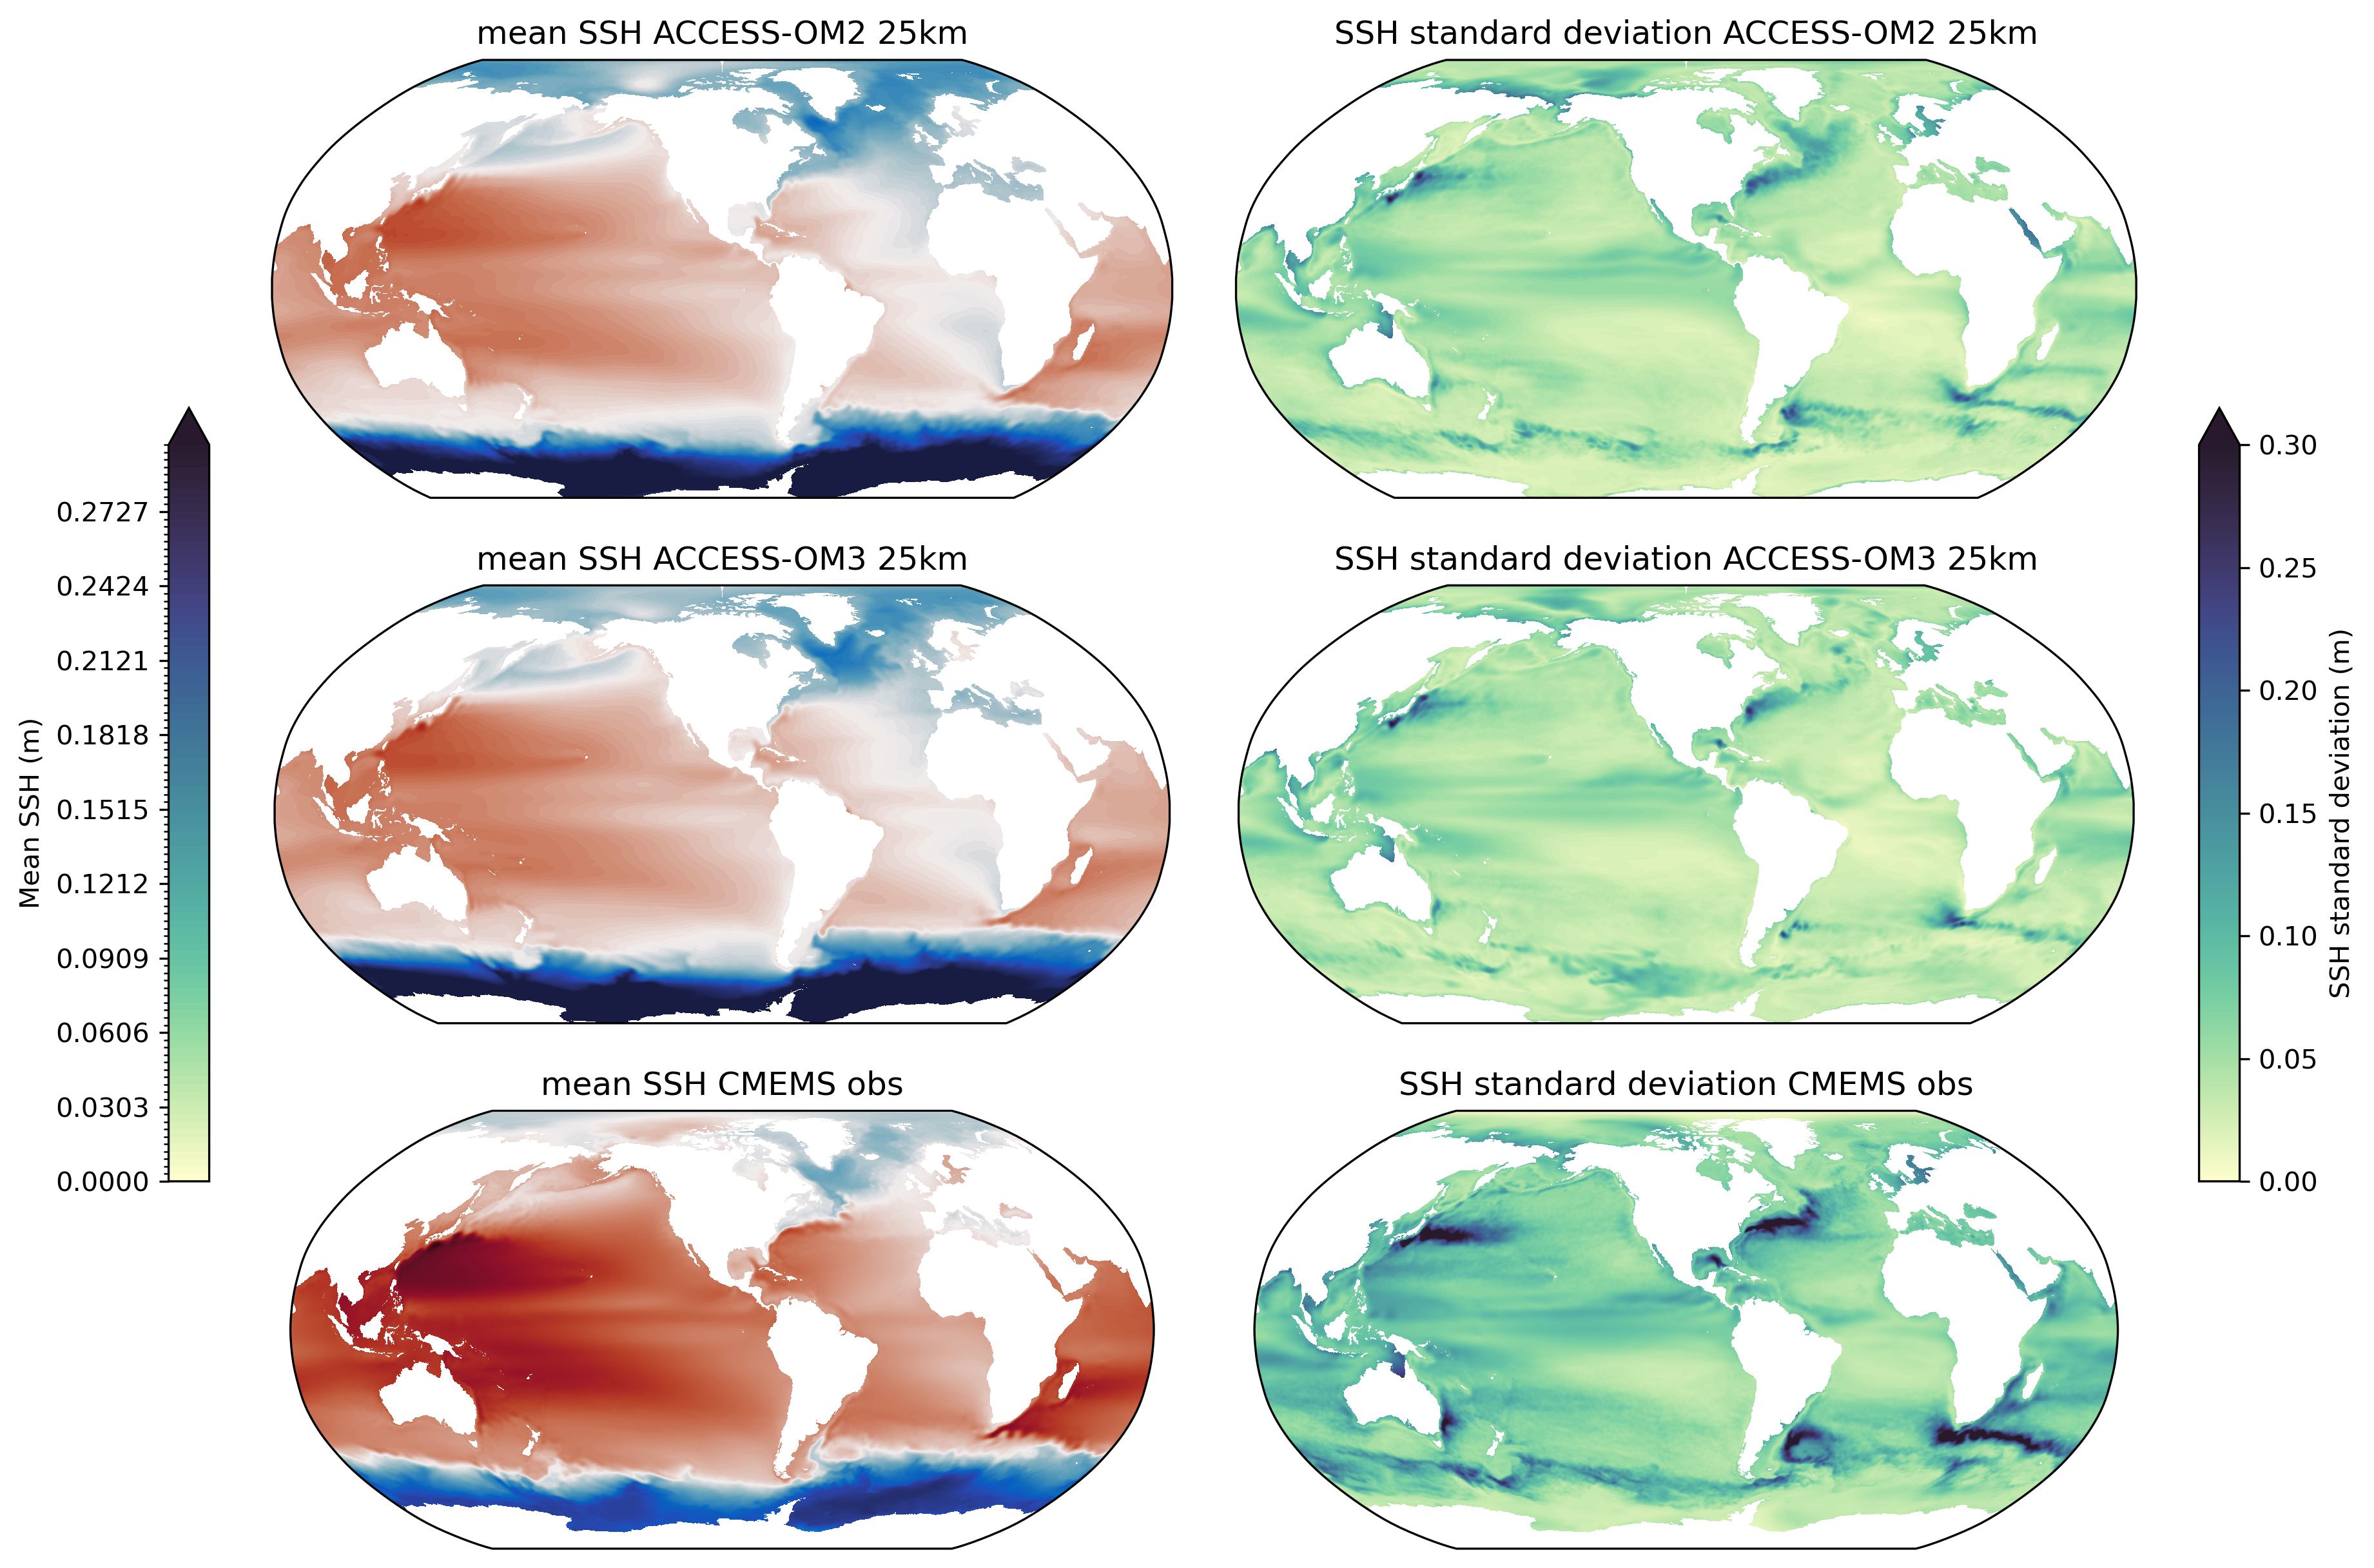

In [29]:
%%time

projection = ccrs.Robinson(central_longitude=-100)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10),
                         subplot_kw={'projection': projection})
plt.subplots_adjust(wspace=-0.15)

max_std = 0.3
max_mean = 1.65

# mean SSH plots
ax = axes[0, 0]
p1 = ssh025_mean.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = -max_mean,
    vmax = +max_mean,
    add_colorbar=False,
    cmap = cm.cm.balance,
    transform = ccrs.PlateCarree())
ax.set_title('mean SSH ACCESS-OM2 25km')

ax = axes[1, 0]
p1 = model_mean.plot.contourf(
    ax = ax,
    x = "xh",
    y = "yh",
    levels = 100,
    vmin = -max_mean,
    vmax = +max_mean,
    add_colorbar=False,
    cmap = cm.cm.balance,
    transform = ccrs.PlateCarree())
ax.set_title('mean SSH ACCESS-OM3 25km')

ax = axes[2, 0]
p1 = obs_ssh_mean.plot(ax=ax, transform=ccrs.PlateCarree(),
                       cmap=cm.cm.balance, vmin=-max_mean, vmax=max_mean, add_colorbar=False)
ax.set_title('mean SSH CMEMS obs')

# std SSH plots
ax = axes[0, 1]
p2 = ssh025_std.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = 0,
    vmax = max_std,
    add_colorbar=False,
    cmap = cm.cm.deep,
    transform = ccrs.PlateCarree())
ax.set_title('SSH standard deviation ACCESS-OM2 25km')

ax = axes[1, 1]
p1 = model_std.plot.contourf(
    ax = ax,
    x = "xh",
    y = "yh",
    levels = 100,
    vmin = 0,
    vmax = max_std,
    add_colorbar=False,
    cmap = cm.cm.deep,
    transform = ccrs.PlateCarree())
ax.set_title('SSH standard deviation ACCESS-OM3 25km')

ax = axes[2, 1]
p2 = obs_ssh_std.plot(ax=ax, transform=ccrs.PlateCarree(),cmap=cm.cm.deep, vmin=0, vmax=max_std, add_colorbar=False)
ax.set_title('SSH standard deviation CMEMS obs')

# Colorbars
ax_cb1 = plt.axes([0.13, 0.3, 0.015, 0.4])
cb = plt.colorbar(p1, cax=ax_cb1, extend='both', label='Mean SSH (m)')
ax_cb1.yaxis.set_ticks_position('left')
ax_cb1.yaxis.set_label_position('left')

ax_cb2 = plt.axes([0.88, 0.3, 0.015, 0.4])
cb = plt.colorbar(p2, cax=ax_cb2, extend='max', label='SSH standard deviation (m)');